<a href="https://colab.research.google.com/github/Hramchenko/Handwritting/blob/master/no_tf_Att_HTR_tf_unif_att_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
print("Device " + torch.cuda.get_device_name(0))
device = torch.device("cuda:0")
#device = torch.device("cpu")
print(device)

Device Tesla K80
cuda:0


In [0]:
batch_size = 100

In [0]:
import sys
sys.path.append("./Handwritting/")
from IAMWords import IAMWords
image_width = 1500
image_height = 200
train_set = IAMWords("train", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1)
test_set = IAMWords("test", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1)

Reading ./IAM/words.train.pkl...
Reading finished
Reading ./IAM/words.test.pkl...
Reading finished


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.core.debugger import set_trace
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [0]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [0]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [0]:
class FullyConnectedX(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnectedX, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [0]:
batch = train_set.make_batch(use_binarization=False)
data, target = batch
target = target.to(device)
data = data/255.0
data = data.view(batch_size, 1, image_width, image_height).to(device)

In [0]:
class HTREncoder(nn.Module):
    def __init__(self, batchnorm=True, dropout=False):
        super(HTREncoder, self).__init__()
        
        self.convolutions = nn.Sequential(
        ConvLayer([1, 4, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([4, 16, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([16, 32, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([32, 64, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([64, 64, 1], padding=0, stride=(1,11), bn=batchnorm, pool_layer=None))
        
        #self.fc = FullyConnectedX([64*15*49, 64*49*3, 64*49], activation_fn=nn.ReLU())
    
    def forward(self, x):
        h = self.convolutions(x)
        h = h.squeeze(-1)
        #h = h.flatten(start_dim=1)
        #h = self.fc(h)
        #h = F.max_pool2d(h, [1, h.size(1)], padding=[0, 0])
        #h = h.permute([2, 3, 0, 1])[0]
        #h = h.permute([2, 3, 0, 1])
        
        return h
    

In [0]:
encoder = HTREncoder().to(device)

In [0]:
c = encoder(data)
c.shape

torch.Size([100, 64, 92])

In [0]:
64*15*49


47040

In [0]:
def to_onehot(x, n):
    one_hot = torch.zeros((x.shape[0], n)).to(device)
    one_hot.scatter_(1, x[:, None], 1.)
    if device is not None:
        one_hot = one_hot.to(device)
    return one_hot  

In [0]:
class HTRDecoder(nn.Module):
    def __init__(self, ntoken, encoded_width=92, encoded_height=64, batchnorm=True, dropout=False, rnn_type="LSTM"):
        super(HTRDecoder, self).__init__()
        self.ntoken = ntoken
        self.encoded_width = encoded_width
        self.encoded_height = encoded_height
        self.lstm_size = 256
        self.lstm_layers = 2
        self.rnn_type = rnn_type
        self.emb_size = 128
        features_size = self.encoded_height*encoded_width + self.emb_size
        from math import floor
        lstm_inp_size = floor(features_size*0.3)
        
        if rnn_type == "LSTM":
          self.rnn = nn.LSTM(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        else:
          self.rnn = nn.GRU(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        self.embedding = nn.Embedding(ntoken, self.emb_size)
        self.decoder = nn.Linear(1*self.lstm_size*1, ntoken)#*batch_size)
        self.drop = nn.Dropout(0.0)

        self.fc = FullyConnectedX([features_size, floor(features_size*0.7), floor(features_size*0.5), lstm_inp_size], activation_fn=nn.ReLU(), last_fn=nn.Tanh())
        
        self.attention = FullyConnectedX([self.lstm_size*2 + self.encoded_height*encoded_width, self.encoded_height*encoded_width*2,  self.encoded_width], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
#        self.attention = FullyConnectedX([self.lstm_size*2 + self.encoded_height*encoded_width, self.encoded_height*encoded_width*2,  self.encoded_height*self.encoded_width], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
        print(self.attention)
        #self.concatenated = torch.FloatTensor(24, )
        self.attention_weights = None
    
    def forward(self, x, prev, hidden=None):
        #set_trace()
        x = self.drop(x).squeeze()
        if hidden is not None:
          
          hidden_m = hidden.permute(1, 0, 2)

          hidden_m = hidden_m.flatten(start_dim=1)
          #print(hidden.shape)
          
          attention_inp = torch.cat([x, hidden_m], dim=1).detach()
          self.attention_weights = self.attention(attention_inp)
          #print(x.shape)
          #print(hidden_m.shape)
          #print(attention_inp.shape)
          #print(self.attention_weights.shape)
          
          self.attention_weights = F.softmax(self.attention_weights, dim=1)
          #print(self.attention_weights.shape)
          
          self.attention_weights = self.attention_weights.repeat([1, self.encoded_height])
          #print(self.attention_weights.shape)
                  
          #print(x.shape)
          x = x * self.attention_weights
          #print(x.shape)
          #raise Exception()
          
          
          #print("********************")
          #print(x)
          #print(attention_w)
          #print(X)
          #print("---------------")
        emb = self.embedding(prev).squeeze().detach()
        
        
        x = torch.cat([x, emb], dim=1)
        
        x = self.fc(x)
        x = x.unsqueeze(0)
        x, hidden = self.rnn(x, hidden)
        x = x.squeeze(dim=0)
        x = self.drop(x)
        x = self.decoder(x)
        
        x = F.log_softmax(x, dim=1)
        
        return x, hidden  
      
    def makeHidden(self):
      if self.rnn_type == "LSTM":
        h1 = torch.zeros(self.lstm_layers, batch_size, self.lstm_size).to(device)
        h2 = torch.zeros(self.lstm_layers, batch_size, self.lstm_size).to(device)
        return (h1, h2)
      else:
        h1 = torch.zeros(self.lstm_layers, batch_size, self.lstm_size).to(device)
        return h1
      
decoder = HTRDecoder(len(train_set.codes), rnn_type="GRU").to(device)

FullyConnectedX(
  (model): Sequential(
    (0): Linear(in_features=6400, out_features=11776, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=11776, out_features=92, bias=True)
    (3): Tanh()
  )
)


In [0]:
START = train_set.codes['<START>']
current_symbol = torch.LongTensor(batch_size, 1).to(device)
current_symbol[:, :] = START

In [0]:
23*64


1472

Training epoch 0...
TF: False


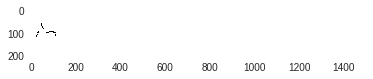

  in -> on


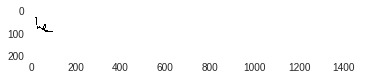

  he -> on


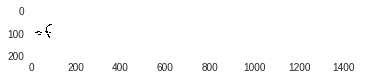

  of -> on
  Batch: 100 Loss: 3.346562740802765
TF: False


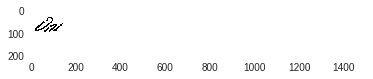

  One -> the


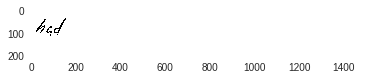

  had -> the


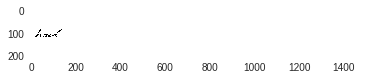

  had -> the
  Batch: 200 Loss: 2.713155725797017
TF: False


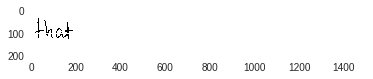

  that -> thet


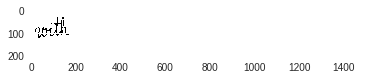

  with -> thet


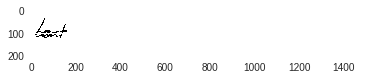

  boat -> thet
  Batch: 300 Loss: 2.550446781317393
Training epoch 1...
TF: False


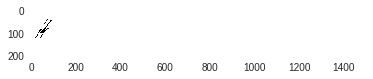

  it -> of


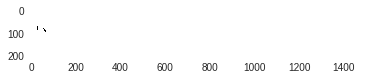

  in -> of


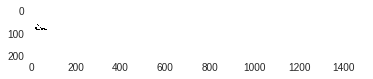

  in -> oo
  Batch: 100 Loss: 2.610599870681763
TF: False


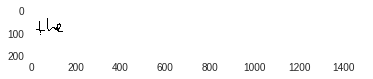

  the -> the


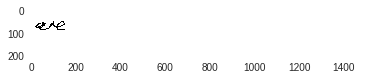

  are -> the


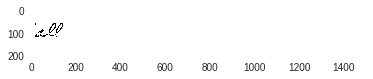

  all -> the
  Batch: 200 Loss: 2.472293254534403
TF: False


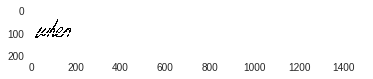

  when -> thee


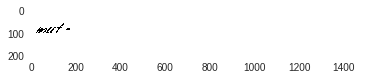

  mut- -> thee


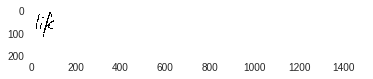

  life -> that
  Batch: 300 Loss: 2.4671055491765337
Training epoch 2...
TF: False


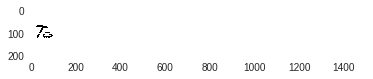

  To -> on


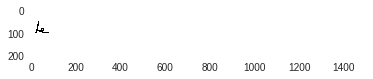

  he -> on


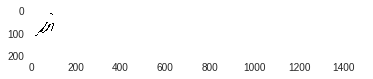

  in -> on
  Batch: 100 Loss: 2.557720330953598
TF: False


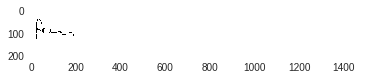

  fun -> the


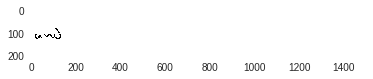

  and -> the


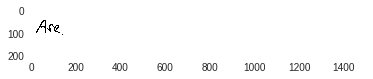

  Are -> the
  Batch: 200 Loss: 2.463112752437591
TF: False


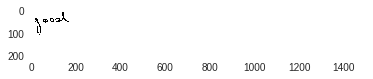

  good -> thet


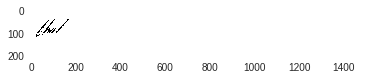

  that -> thet


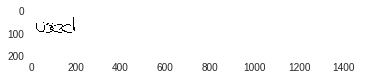

  used -> thet
  Batch: 300 Loss: 2.4371545465787263
Training epoch 3...
TF: False


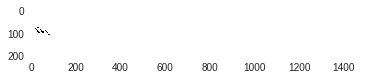

  in -> oo


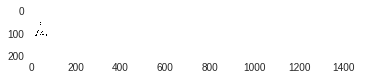

  in -> oo


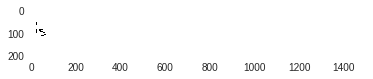

  is -> oo
  Batch: 100 Loss: 2.5425585210323334
TF: False


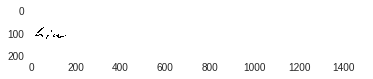

  him -> the


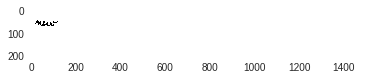

  new -> the


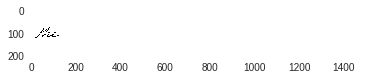

  the -> the
  Batch: 200 Loss: 2.4311622548103333
TF: False


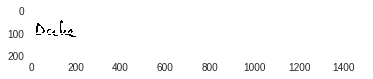

  Duke -> thee


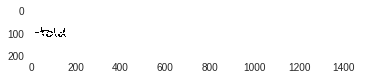

  told -> thee


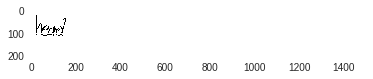

  head -> taee
  Batch: 300 Loss: 2.4345729955037445
Training epoch 4...
TF: False


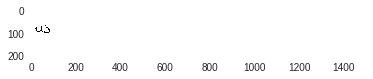

  us -> oo


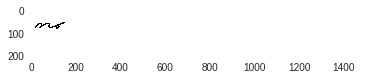

  no -> io


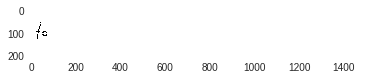

  to -> oo
  Batch: 100 Loss: 2.5541897201538086
TF: False


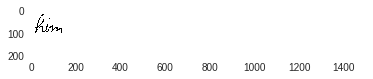

  him -> the


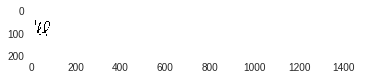

  'll -> the


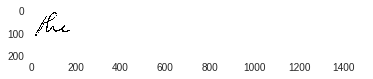

  the -> the
  Batch: 200 Loss: 2.4384879263242083
TF: False


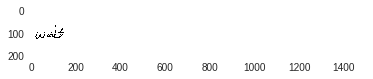

  wait -> aaee


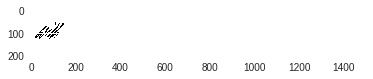

  with -> ahee


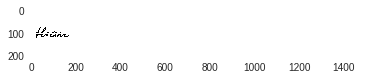

  than -> taee
  Batch: 300 Loss: 2.4370415321985877
Training epoch 5...
TF: False


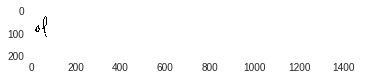

  of -> oo


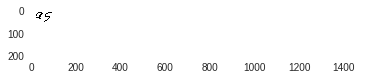

  as -> oo


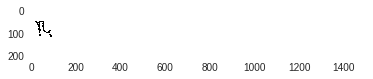

  Mr -> oo
  Batch: 100 Loss: 2.508061697483063
TF: False


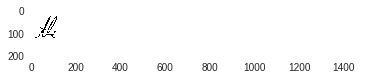

  the -> the


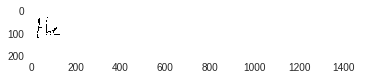

  the -> the


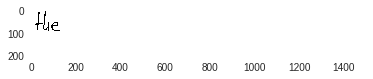

  the -> the
  Batch: 200 Loss: 2.3843499978383376
TF: False


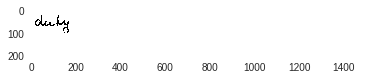

  duty -> thee


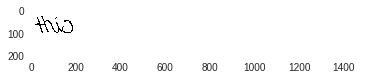

  this -> thee


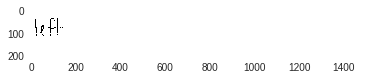

  left -> taee
  Batch: 300 Loss: 2.4336910502115887
Training epoch 6...
TF: False


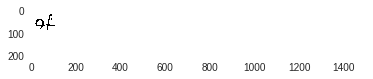

  of -> on


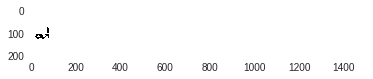

  at -> on


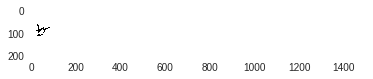

  to -> on
  Batch: 100 Loss: 2.5433258855342866
TF: False


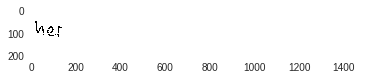

  her -> the


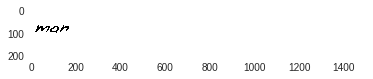

  man -> the


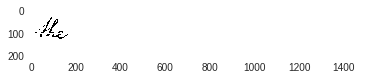

  the -> the
  Batch: 200 Loss: 2.409045735200247
TF: False


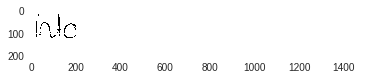

  into -> waee


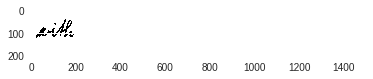

  with -> taee


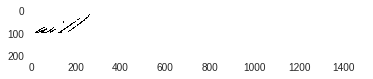

  will -> taee
  Batch: 300 Loss: 2.4246897045771285
Training epoch 7...
TF: False


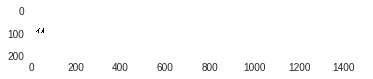

  11 -> in


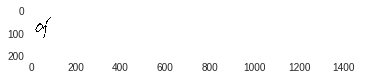

  of -> in


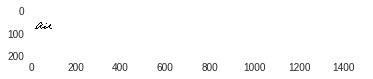

  an -> in
  Batch: 100 Loss: 2.5085972690582277
TF: False


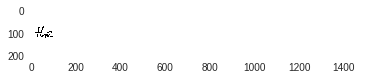

  the -> the


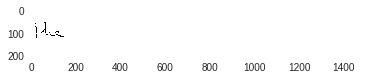

  the -> the


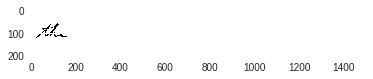

  the -> the
  Batch: 200 Loss: 2.4514323139190672
TF: False


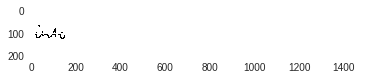

  into -> thee


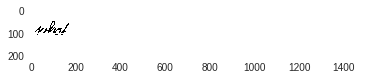

  what -> thae


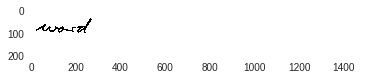

  word -> whee
  Batch: 300 Loss: 2.43985205411911
Training epoch 8...
TF: False


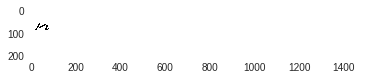

  in -> of


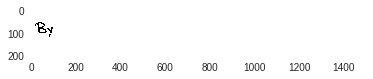

  By -> io


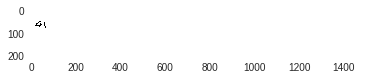

  as -> io
  Batch: 100 Loss: 2.486424186229706
TF: False


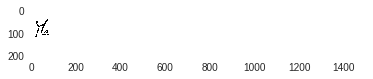

  the -> the


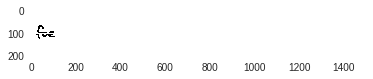

  foe -> the


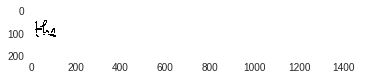

  the -> the
  Batch: 200 Loss: 2.402660580476126
TF: False


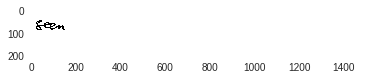

  seen -> thae


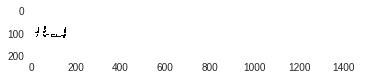

  that -> thae


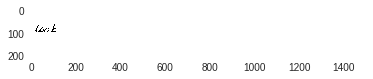

  look -> whae
  Batch: 300 Loss: 2.4165948112805693
Training epoch 9...
TF: False


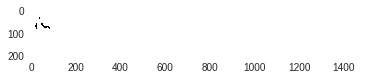

  in -> oo


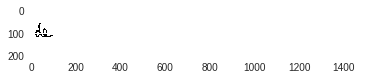

  de -> oo


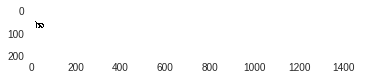

  so -> oo
  Batch: 100 Loss: 2.552204604148865
TF: False


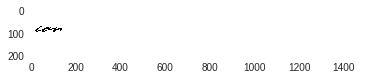

  can -> the


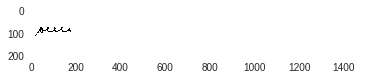

  run -> the


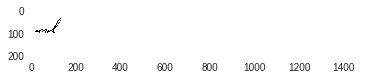

  and -> the
  Batch: 200 Loss: 2.388428857326507
TF: False


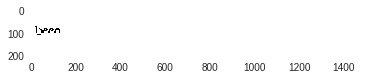

  been -> thee


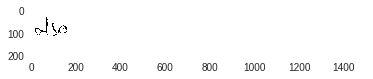

  also -> taae


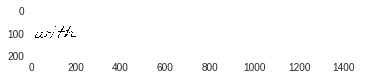

  with -> taae
  Batch: 300 Loss: 2.415678583780925
Training epoch 10...
TF: False


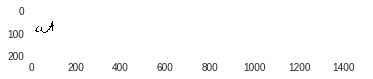

  at -> of


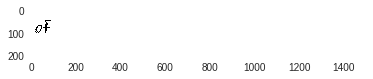

  of -> of


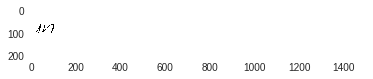

  in -> of
  Batch: 100 Loss: 2.5178414463996885
TF: False


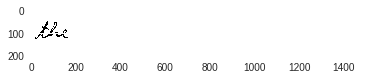

  the -> the


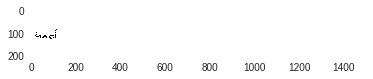

  had -> the


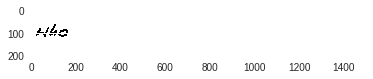

  who -> the
  Batch: 200 Loss: 2.4144740962982185
TF: False


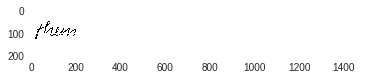

  them -> taae


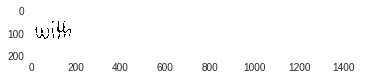

  with -> taae


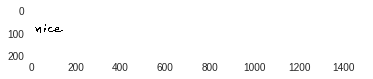

  nice -> taae
  Batch: 300 Loss: 2.428210911750793
Training epoch 11...
TF: False


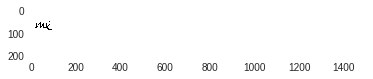

  me -> oo


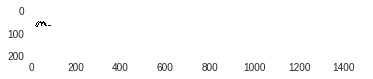

  on -> io


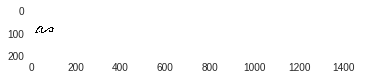

  as -> io
  Batch: 100 Loss: 2.495120705366135
TF: False


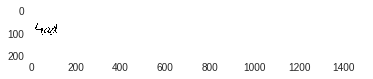

  had -> the


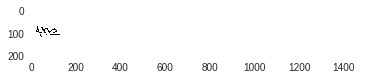

  the -> the


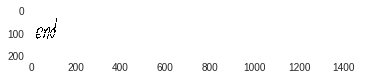

  end -> the
  Batch: 200 Loss: 2.396544094085693
TF: False


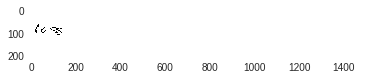

  less -> taat


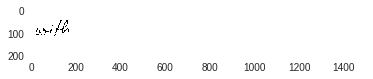

  with -> taae


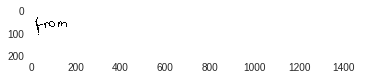

  from -> taee
  Batch: 300 Loss: 2.4216532262166344
Training epoch 12...
TF: False


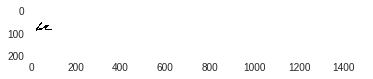

  we -> of


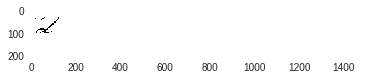

  'd -> oo


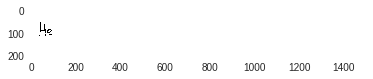

  He -> oo
  Batch: 100 Loss: 2.4398598301410677
TF: False


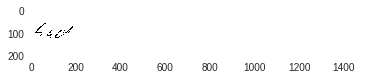

  had -> the


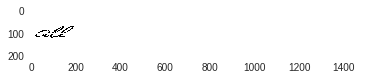

  all -> the


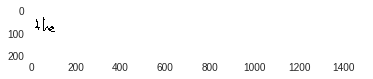

  the -> the
  Batch: 200 Loss: 2.370002498626709
TF: False


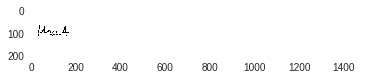

  that -> toae


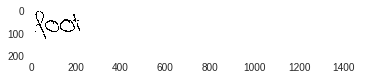

  foot -> taae


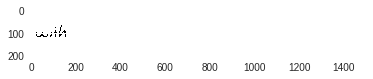

  with -> toae
  Batch: 300 Loss: 2.4141044664382934
Training epoch 13...
TF: False


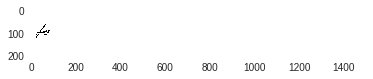

  to -> oo


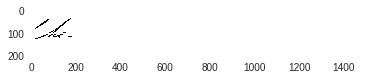

  he -> oo


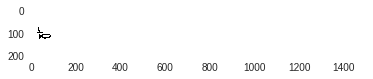

  to -> oo
  Batch: 100 Loss: 2.3983273661136626
TF: False


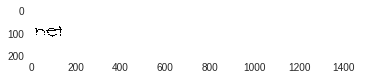

  net -> the


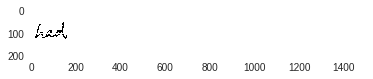

  had -> the


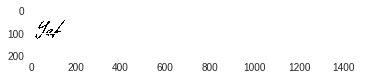

  Yet -> the
  Batch: 200 Loss: 2.3932979043324787
TF: False


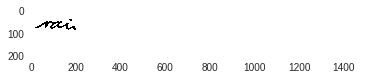

  rain -> waae


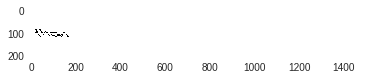

  than -> taae


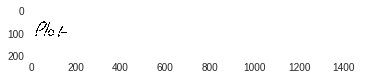

  Plot -> taae
  Batch: 300 Loss: 2.4216981911659246
Training epoch 14...
TF: False


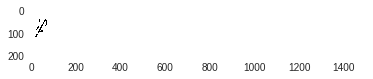

  if -> io


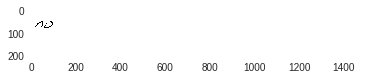

  no -> in


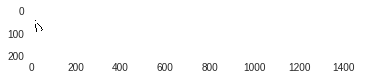

  is -> in
  Batch: 100 Loss: 2.4942632842063905
TF: False


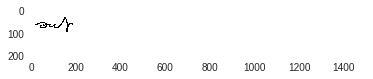

  out -> the


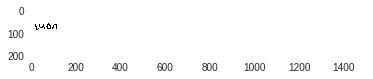

  man -> the


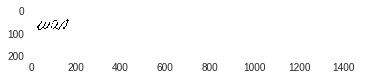

  was -> the
  Batch: 200 Loss: 2.370573606491089
TF: False


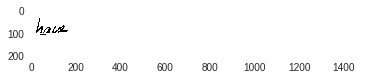

  have -> taae


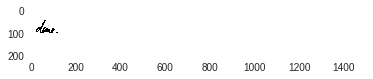

  done -> taae


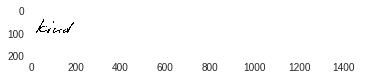

  kind -> taae
  Batch: 300 Loss: 2.4247056992848717
Training epoch 15...
TF: False


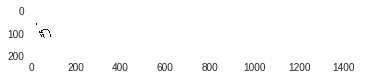

  in -> oo


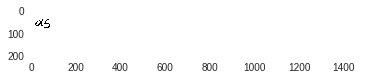

  as -> io


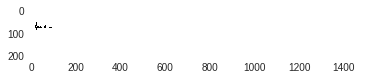

  me -> oo
  Batch: 100 Loss: 2.457934172153473
TF: False


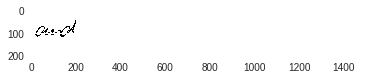

  and -> the


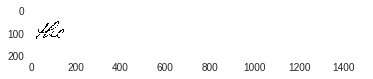

  the -> the


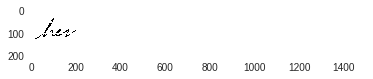

  her -> the
  Batch: 200 Loss: 2.3967134372393293
TF: False


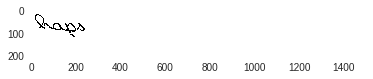

  haps -> toae


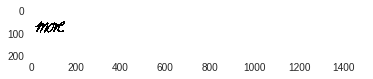

  more -> toae


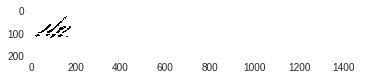

  else -> taae
  Batch: 300 Loss: 2.4102559137344364
Training epoch 16...


In [0]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=0.00005)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=1e-4, weight_decay=0.00005)

criterion = nn.NLLLoss()

teacher_forcing_ratio = 0#0.5

from random import random


def train(epoch):
  print("Training epoch " + str(epoch) + "...")
  
  freq = 100
  
  train_set.to_start()
  batch_idx = 0
  c_loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  recognition_result = torch.LongTensor(batch_size, 30+1).to(device)
  old_symbol = torch.LongTensor(batch_size, 1).to(device)
  
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  
  
  
  while True:
    batch = train_set.make_batch()
    if batch is None:
      break
    encoder.zero_grad()
    decoder.zero_grad()
    
    orig_data, target = batch
    if target.shape[1] > 4:
      break
    data = orig_data/255.0
    data = data.view(batch_size, 1, image_width, image_height).to(device)
    target = target.to(device)
    hidden = decoder.makeHidden()    

    loss = 0
    enc = encoder(data)
    #print(enc.shape)
    s = enc.permute(1, 0, 2)
    #print(s.shape)
    s = s.flatten(start_dim=1).view(1, batch_size, -1)
    
    old_symbol[:, 0] = START
    use_teacher_forcing = True if random() < teacher_forcing_ratio else False

    for i in range(0, target.shape[1]):

      dec, hidden = decoder(s, old_symbol, hidden)
      
      recognition_result[:, i] = dec.topk(1, dim=1)[1].flatten().detach()
      if use_teacher_forcing:
        old_symbol[:, 0] = target[:, i]
      else:
        old_symbol[:, 0] = recognition_result[:, i]
      #import pdb; pdb.set_trace()

      loss += criterion(dec, target[:, i])
    c_loss += loss.item()/(target.shape[1] + 0)
    if (batch_idx % freq == 0) and (batch_idx != 0):
      print("TF: " + str(use_teacher_forcing))
      if True:#not use_teacher_forcing:
        for k in range(0, min(3, target.shape[0])):
            decoded = recognition_result[k,0:target.shape[1]]
            plt.imshow(orig_data[k].cpu(), cmap="gray")
            plt.show()
            print("  " + train_set.decode_word(target[k,:]) + " -> " + train_set.decode_word(decoded))
      c_loss /= freq 
      print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
      c_loss = 0
    loss.backward()
    grad_clip = 0.1
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    batch_idx += 1

for i in range(0, 100):
  train(i)
